In [109]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

### Loading data

In [110]:
# UC admissions data by ethnicity
years = ['2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023']

ethnicity = {}
gender = {}
gpa = {}
for year in years:
    ethnicity[f'{year}'] = pd.read_csv(f'ethnicity/{year}_ethn.csv', encoding='utf-16le', delimiter='\t', on_bad_lines='skip')
    gender[f'{year}'] = pd.read_csv(f'gender/{year}_gender.csv', encoding='utf-16le', delimiter='\t', on_bad_lines='skip')
    gpa[f'{year}'] = pd.read_csv(f'GPA/{year}_gpa.csv', index_col=0)

# specifically for 2017 ethnicity data, it uses utf-8 for some reason
ethnicity['2017'] = pd.read_csv(f'ethnicity/2017_ethn.csv', encoding='utf-8')

# median income by household at city level from census
census = pd.read_csv('https://raw.githubusercontent.com/wanning-lu/MATH-189-Final-Project/master/Census/ACSST1Y2022.S1903-2024-05-27T042652.csv', index_col = 0)


#scraped park access data
parks = pd.read_csv("https://raw.githubusercontent.com/wanning-lu/MATH-189-Final-Project/master/park_access/parks_data.csv", encoding='utf-8')
#Clean
parks['City'] = parks['City'].str.replace(',California', '') 

### Filtering income data to contain only Californian cities

In [111]:
# using regex
pattern = r'California'  # this pattern matches any column name containing 'Measure'
# use filter to select columns that match the regex pattern
matching_columns = census.filter(regex=pattern).columns
# drop columns that do not match the pattern
census_filtered = census[matching_columns]

# repeat this so we narrow the data down to median income of californian cities
estimates = r'Estimate'
matching_columns2 = census_filtered.filter(regex=estimates).columns
census_income = census_filtered[matching_columns2]

Inc = r'Median income'
matching_columns3 = census_income.filter(regex=Inc).columns
california_income = census_filtered[matching_columns3]

# clean up column names
column_mapping = {col: col.split(',')[0] for col in california_income.columns}

# rename columns
california_income = california_income.rename(columns=column_mapping)

# clean up column names some more
def remove_last_word(s):
    return ' '.join(s.split()[:-1])

column_mapping = {col: remove_last_word(col) for col in california_income.columns}

california_income = california_income.rename(columns=column_mapping)

# lets get the cities as rows so we can merge it a bit easier
california_income = california_income.T

# lets bring the cities into a col so easier to merge
california_income = california_income.reset_index(drop=False)

# rename column
california_income = california_income.rename(columns={'index': 'City', '\xa0\xa0\xa0\xa0Households': 'Household Income'})

# lets keep only city and income data
california_income = california_income[['City', 'Household Income']]
# lets make income into ints
california_income['Household Income'] = california_income['Household Income'].str.replace(',', '').astype(int)
california_income.head()

Label (Grouping),City,Household Income
0,California!!Median income,91551
1,Alameda,131116
2,Alhambra,72406
3,Anaheim,85133
4,Antioch,100178


### NaN values in our UC and Park access data

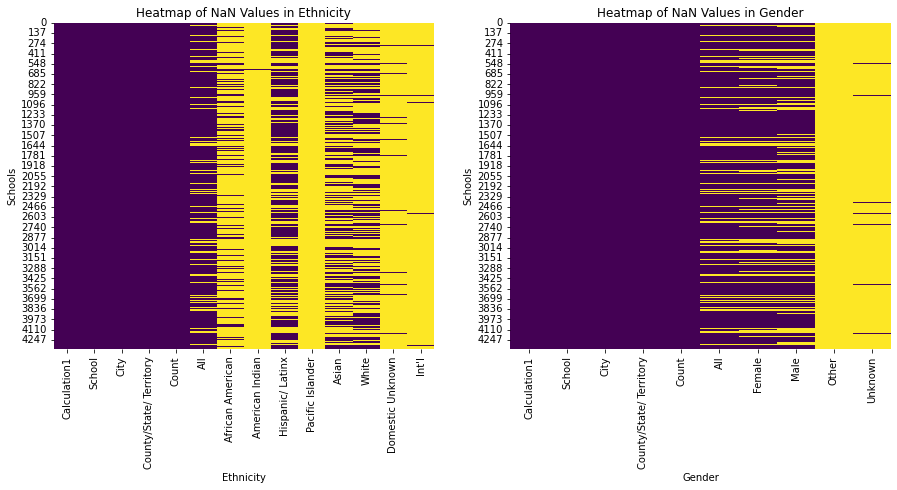

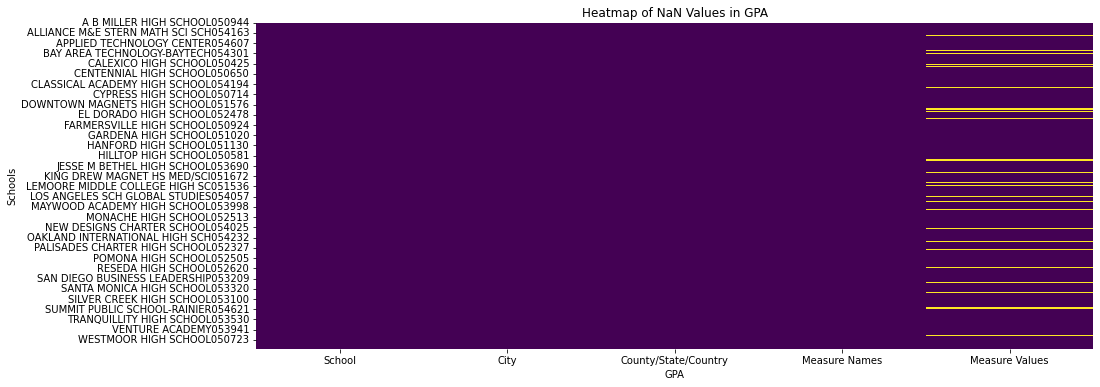

<Figure size 720x432 with 0 Axes>

In [112]:
#lets see how many Na values we have in our data

nan_df_ethn = ethnicity['2016'].isna()
nan_df_gender = gender['2016'].isna()
nan_df_gpa = gpa['2016'].isna()

# Create a figure with subplots 
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
fig2, ax2 = plt.subplots(1, 1, figsize=(15, 6))

# Set up the matplotlib figure
plt.figure(figsize=(10, 6))

# Create a heatmap
sns.heatmap(nan_df_ethn, cmap='viridis', cbar=False, ax=ax[0])
sns.heatmap(nan_df_gender, cmap='viridis', cbar=False, ax=ax[1])
sns.heatmap(nan_df_gpa, cmap='viridis', cbar=False, ax=ax2)


# Add labels and title
ax[0].set_xlabel('Ethnicity')
ax[0].set_ylabel('Schools')
ax[0].set_title('Heatmap of NaN Values in Ethnicity')

ax[1].set_xlabel('Gender')
ax[1].set_ylabel('Schools')
ax[1].set_title('Heatmap of NaN Values in Gender')

ax2.set_xlabel('GPA')
ax2.set_ylabel('Schools')
ax2.set_title('Heatmap of NaN Values in GPA')

# Show the plot
plt.show()

The documentation say for any category with < 3 students, it is entered as null. We will have decide how we will deal with this.

### Merge DataFrames across the categories

In [113]:
merged_years = {}
for year in years:
    merged_years[f'{year}'] = pd.merge(ethnicity[f'{year}'], california_income, on='City', how='inner')
    merged_years[f'{year}'] = pd.merge(merged_years[f'{year}'], gender[f'{year}'], on=['Calculation1', 'School', 'County/State/ Territory','Count','All', 'City'], how='inner')
    merged_years[f'{year}'] = pd.merge(merged_years[f'{year}'], gpa[f'{year}'], on=['City','School'], how='inner')
    merged_years[f'{year}'] = pd.merge(merged_years[f'{year}'], parks, on='City', how='inner')  # Merge with parks directly using the 'City' column
    merged_years[f'{year}'] = merged_years[f'{year}'].set_index('Count')


# merged_df_16 = pd.merge(ethn_16, california_income, on='City', how='inner')
# merged_df_16 = pd.merge(merged_df_16, gen_16, on=['Calculation1', 'School', 'County/State/ Territory','Count','All', 'City'], how='inner')
# merged_df_16 = pd.merge(merged_df_16, gpa_16, on=['City','School'], how='inner')
# merged_df_16 = merged_df_16.set_index('Count')

In [114]:
covariance = merged_years['2016']['Household Income'].cov(merged_years['2016']['Parks per 1000 People'])
print(covariance)

2210.1270298128475


In [115]:
merged_years['2016'].columns

Index(['Calculation1', 'School', 'City', 'County/State/ Territory', 'All',
       'African American', 'American Indian', 'Hispanic/ Latinx',
       'Pacific Islander', 'Asian', 'White', 'Domestic Unknown', 'Int'l',
       'Household Income', 'Female', 'Male', 'Other', 'Unknown',
       'County/State/Country', 'Measure Names', 'Measure Values', 'Parks Area',
       'Parks per 1000 People'],
      dtype='object')

### Clean data further

In [116]:
# this adds "app" and "adm" as a column and resets the index to 0-n
#changed this cell I recieved this error: TypeError: reset_index() got an unexpected keyword argument 'name'
for year in years:
    merged_years[year]['status'] = merged_years[year].index
    merged_years[year] = merged_years[year].reset_index(drop=True)

In [117]:
for year in years:
    # remove 'enrolled' rows
    merged_years[year] = merged_years[year].loc[merged_years[year]['status'].isin(['App', 'Adm'])]
    # keep only one gpa - the admits' average gpas
    merged_years[year] = merged_years[year].loc[merged_years[year]['Measure Names'].isin(['Adm GPA'])]

In [118]:
for year in years:
    # preprocess gpa column so that it's weighted
    merged_years[year]['Measure Values'] = merged_years[year].groupby(merged_years[year]['status'])['Measure Values'].transform(lambda x: x * merged_years[year]['All'])
    # now begin merging the rows based on city by gender, ethnicity, and gpa
    merged_years[year] = merged_years[year].groupby(['City', 'status', 'Household Income'])[['All', 'African American', 'American Indian', 'Hispanic/ Latinx', 
                                                                        'Pacific Islander', 'Asian', 'White', 'Domestic Unknown', 'Int\'l', 
                                                                        'Female', 'Male', 'Other', 'Unknown', 'Measure Values']].sum()
    merged_years[year] = merged_years[year].reset_index()

In [119]:
merged_years['2018'].columns

Index(['City', 'status', 'Household Income', 'All', 'African American',
       'American Indian', 'Hispanic/ Latinx', 'Pacific Islander', 'Asian',
       'White', 'Domestic Unknown', 'Int'l', 'Female', 'Male', 'Other',
       'Unknown', 'Measure Values'],
      dtype='object')

In [120]:
# now fix the GPA!
for year in years:
    merged_years[year]['Measure Values'] = merged_years[year].groupby(['City', 'status'])['Measure Values'].transform(lambda x: x / merged_years[year]['All'])

In [121]:
merged_years['2016']

,City,status,Household Income,All,African American,American Indian,Hispanic/ Latinx,Pacific Islander,Asian,White,Domestic Unknown,Int'l,Female,Male,Other,Unknown,Measure Values
0,Alameda,Adm,131116,220.0,10.0,0.0,8.0,0.0,140.0,39.0,3.0,0.0,120.0,98.0,0.0,0.0,3.949851
1,Alameda,App,131116,292.0,19.0,0.0,14.0,0.0,174.0,52.0,5.0,0.0,158.0,132.0,0.0,0.0,3.950483
2,Alhambra,Adm,72406,284.0,0.0,0.0,15.0,0.0,255.0,0.0,0.0,0.0,151.0,123.0,0.0,8.0,3.743325
3,Alhambra,App,72406,381.0,0.0,0.0,44.0,0.0,317.0,0.0,0.0,0.0,203.0,164.0,0.0,10.0,3.743359
4,Anaheim,Adm,85133,447.0,4.0,0.0,213.0,0.0,141.0,62.0,4.0,0.0,259.0,179.0,0.0,0.0,3.829754
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
273,Whittier,App,91457,544.0,11.0,0.0,453.0,0.0,24.0,36.0,0.0,0.0,339.0,194.0,0.0,0.0,3.889014
274,Yorba Linda,Adm,151534,101.0,0.0,0.0,19.0,0.0,44.0,28.0,0.0,0.0,61.0,35.0,0.0,5.0,3.982500
275,Yorba Linda,App,151534,143.0,0.0,0.0,30.0,0.0,55.0,46.0,7.0,0.0,84.0,54.0,0.0,5.0,3.982500
276,Yuba City,Adm,59588,64.0,0.0,0.0,15.0,0.0,32.0,10.0,0.0,0.0,36.0,28.0,0.0,0.0,3.937500


### Grade Inflation 📈🤔

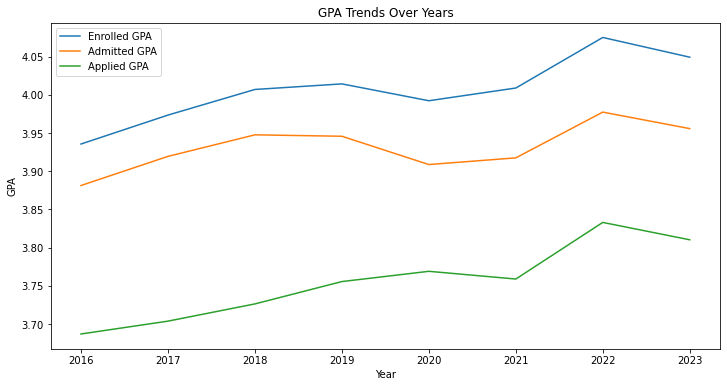

In [122]:
#concat gpa dfs, filter dfs for only necessary data, change get adm/enrolled/applied a

gpa_all_years = pd.concat(gpa.values(), keys=gpa.keys(), names=['Year'])
gpa_filtered = gpa_all_years[['School', 'Measure Names', 'Measure Values']].reset_index()
gpa_pivot = gpa_filtered.pivot_table(index=['Year', 'School'], columns='Measure Names', values='Measure Values').reset_index()
gpa_annual_avg = gpa_pivot.groupby('Year').mean().reset_index()



plt.figure(figsize=(12, 6))

plt.plot(gpa_annual_avg['Year'], gpa_annual_avg['Enrl GPA'], label='Enrolled GPA')
plt.plot(gpa_annual_avg['Year'], gpa_annual_avg['Adm GPA'], label='Admitted GPA')
plt.plot(gpa_annual_avg['Year'], gpa_annual_avg['App GPA'], label='Applied GPA')

plt.xlabel('Year')
plt.ylabel('GPA')
plt.title('GPA Trends Over Years')
plt.legend()
plt.show()


We definitely see an upward trend in the least seven years, but is it a statistically significant increase? Let assess the signifcance by fitting the following regressions.

$$
\text{adm_gpa} = \beta_0 + \beta1\text{year}
$$


$$
\text{applied_gpa} = \beta_0 + \beta1\text{year}
$$


$$
\text{enrolled_gpa} = \beta_0 + \beta1\text{year}
$$

In [123]:
gpa_annual_avg['Year'] = gpa_annual_avg['Year'].astype(int)

# Prepare the independent variable (years) with an intercept
X = sm.add_constant(gpa_annual_avg['Year'])

# Dependent variables 
y_enrl = gpa_annual_avg['Enrl GPA']
y_adm = gpa_annual_avg['Adm GPA']
y_app = gpa_annual_avg['App GPA']

#Enrolled GPA model
model_enrl = sm.OLS(y_enrl, X).fit()

#Admitted GPA model
model_adm = sm.OLS(y_adm, X).fit()

#Applied GPA model
model_app = sm.OLS(y_app, X).fit()

# model summaries
print("Enrolled GPA Model Summary:")
print(model_enrl.summary())

print("\nAdmitted GPA Model Summary:")
print(model_adm.summary())

print("\nApplied GPA Model Summary:")
print(model_app.summary())

Enrolled GPA Model Summary:
                            OLS Regression Results                            
Dep. Variable:               Enrl GPA   R-squared:                       0.764
Model:                            OLS   Adj. R-squared:                  0.724
Method:                 Least Squares   F-statistic:                     19.38
Date:                Wed, 05 Jun 2024   Prob (F-statistic):            0.00456
Time:                        20:10:52   Log-Likelihood:                 20.138
No. Observations:                   8   AIC:                            -36.28
Df Residuals:                       6   BIC:                            -36.12
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -26.9151   

/Users/tomas/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/Users/tomas/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/Users/tomas/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


We can see that the gpa of those enrolled and those who applied does increase significantly (at the 95% significance level). But the gpa of those who were admitted has not increased significantly (at the 95% significance level). What do we make of this? Come back to this later.

#### Enrolled GPA coefficient interpretation:

For each additional year the gpa of students who enrolled into the UC system increases, on average, by 0.0153 gpa points.


#### Accepted GPA coefficient interpretation:
For each additional year the gpa of students who accepted into the UC system increases, on average, by 0.0081 gpa points.

#### Applied GPA coefficient interpretation:
For each additional year the gpa of students who applied the UC system increases, on average, by 0.0193 gpa points.

